## Notebook for training for stock price with rolling fit and rolling forecast
Forecast for last 10% of data. Fit is done in steps of 5 days, forecast is done day by day.
- Sequential model
- LSTM model
- not stationary
- rolling fit
- rolling forecast

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.stats as si
from IPython.display import Image
import datetime
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn import preprocessing, metrics

%matplotlib inline

Using TensorFlow backend.


In [2]:
backup = pd.HDFStore('backup_v06.h5')
#df = backup['df']
#unscaled_seq_predictions = backup['unscaled_seq_predictions']
#unscaled_data = backup['unscaled_data']
#unscaled_lstm_predictions = backup['unscaled_lstm_predictions']
#test_data_unscaled = backup['test_data_unscaled']

### Iron Condor
The iron condor is a investment strategy using four option with the same strike date. More precise, the iron condor uses two vertical spreads, one put spread and a call spread. The put spread consists at of a short put option (P_s) with a strike price below the actual stock price and a long put option (P_l) with a strike price below the short put option P_s. The call spread consists of a short call option (C_s) above the actual stock price and a long call option (C_l) above the short call option C_s. All options have the same strike date and the spread on both legs can vary but is chosen mostly the same.
![title](Condor_strategy.png)
"A trader who buys an iron condor speculates that the spot price of the underlying instrument will be between the short strikes when the options expire where the position is the most profitable. Thus, the iron condor is an options strategy considered when the trader has a neutral outlook for the market. Buying iron condors are popular with traders who seek regular income from their trading capital. An iron condor buyer will attempt to construct the trade so that the short strikes are close enough that the position will earn a desirable net credit, but wide enough apart so that it is likely that the spot price of the underlying will remain between the short strikes for the duration of the options contract. The trader would typically play iron condors every month (if possible) thus generating monthly income with the strategy." [https://en.wikipedia.org/wiki/Iron_condor]

### Goal of the project
The goal of the project is to find a strategy to maximise the profit with an iron condor. The ideal short and long spreads should be found at any time based on data of the underlying stock and of the indices S&P500 and Nasdaq

In [4]:
def get_data(var_name,name):
    # reads in csv into DataFrame, keeps Adj Close and Volume and calculates rolling averages and 
    # rolling standard deviation of Adj Close for 4, 9 and 18 days
    # var_name: path to csv file
    # name: name of the column df
    df = pd.read_csv('data/'+var_name+'.csv',index_col='Date', parse_dates=True)
    df.rename(columns={"Adj Close": name, "Volume": name+'_volume', "Open": name+'_open'}, inplace = True)
    df.rename(columns={"High": name+'_high', "Low": name+'_low', "Close": name+'_close'}, inplace = True)
    #df.drop(['Open','High','Low','Close'],axis=1, inplace = True)
    #if name == 'google':
        #df['google_45d'] = df['google'].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df[name+'_ra_04'] = df[name].rolling('4d').mean()
    df[name+'_std_04'] = df[name].rolling('4d').std()
    df[name+'_ra_09'] = df[name].rolling('9d').mean()
    df[name+'_std_09'] = df[name].rolling('9d').std()
    df[name+'_ra_18'] = df[name].rolling('18d').mean()
    df[name+'_std_18'] = df[name].rolling('18d').std()
    return df

In [5]:
def sigma_fct(df, name, days = 10):
    # For Black-Scholes I need the volatility of return of the underlying assets in the last days
    # based on https://www.wikihow.com/Calculate-Historical-Stock-Volatility
    # First the ln of daily returns is calculated for each element of names
    for name in names:
        a=pd.DataFrame()
        a['ln_daily_return'] = np.log(df[name] / df[name].shift(1))
        # next the rolling average (mean) over certain days is calculated
        a['rol_avg'] =  a['ln_daily_return'].rolling(str(days)+'d').mean()
        # next deviation from the mean is calculated
        a['dev_mean'] = a['ln_daily_return'] - a['rol_avg']
        # next variance is calculated for certain days
        a['dev_mean_sq'] = a['dev_mean']**2
        a['variance'] = a['dev_mean_sq'].rolling(str(days)+'d').sum()/(a['dev_mean_sq'].rolling(str(days)+'d').count()-1)
        # volatility is square root of variance
        # do you need annual volatility?
        df[name + '_daily_vol'] = np.sqrt(a['variance'])*np.sqrt(252) # 252 trading days in a year
        #df.drop(['ln_daily_return'])#,'rol_avg','dev_mean','dev_mean_sq','variance'])
        #return df[name + '_daily_vol']
    return df

In [7]:
def stationary_timeseries(df, damned_list = ['volume','std','short','daily']):
    # makes columns in df that are not in damned list stationary. Means it calculates the 
    # difference row by row
    columns = df.columns
    df_sta = pd.DataFrame()
    for column in columns:
        if any(elem in column for elem in damned_list):
            df_sta[column] = df[column]
        else:
            df_sta[column+'_sta'] = df[column].shift(1) - df[column]
    df_sta.dropna(inplace = True)  # to make sure we have all the data on all the days
    return df_sta

In [8]:
def get_df(var_name_list,name_list):
    # takes list paths of csv files and names and passes it on to get_data.
    # Gets df from get_data and merges them on 'Date'
    # Calls sigma_fct to get sigma of daily returns 
    # var_name_list: list of paths to csv files
    # name: list of names the columns of df
    i=0
    for var_name in var_name_list:
        if i == 0:
            df = get_data(var_name, name_list[i])
        else:
            df = pd.merge(df,get_data(var_name, name_list[i]),on='Date')
        i += 1
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    
    df = sigma_fct(df,names)
    df=df[23:] # drop first entries to get clean results

    return df

In [9]:
def get_target_data(df, name):
    # function to create the target data
    # name: name of the column the target data is created of
    df[name+'_45d'] = df[name].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    # df['short_call'] shows the perfect short call. If you would have shorted a call option with a strike price 
    # exactly the same as the stock price 45 days later, you made maximum profit. Therefore this is the target 
    # value for the short call option. The minimum is 0, so we never short a call option with a strike price
    # below the stock price right now. The same for the short put option
    #df['short_call'] = [x/y-1 if x/y > 1 else 0 for x,y in df[[name+'_45d', name]].values]
    #df['short_put'] = [1-x/y if x/y < 1 else 0 for x,y in df[[name+'_45d', name]].values]
    return df

In [10]:
var_names = ['GOOG','S&P','Nasdaq2']
names = ['google','s&p','nasdaq']
df = get_df(var_names, names)
df = get_target_data(df, 'google')
df.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-21,130.764862,134.182053,123.188263,130.725006,130.725006,20565700,136.935478,8.750923,143.875715,10.798013,...,1392.540009,68.742234,1452.251430,95.188063,1541.462141,127.530682,0.716470,0.802275,0.738519,156.946732
2008-11-24,134.127258,134.470963,124.040070,128.239334,128.239334,20184700,129.482170,1.757636,137.580147,9.599201,...,1428.184998,61.992083,1420.705017,68.914436,1498.502503,101.345711,0.529842,0.864400,0.777819,155.761169
2008-11-25,133.838348,142.794769,133.160873,140.498383,140.498383,21623100,134.368858,8.668457,137.997038,8.831976,...,1468.375000,5.154837,1426.994298,65.073432,1483.279999,90.035297,0.833833,0.791313,0.710049,156.573120
2008-11-26,139.616684,147.178345,137.584305,145.499634,145.499634,12760800,138.079117,8.880829,137.425609,8.059325,...,1489.616659,36.971751,1434.144287,74.235572,1487.035382,87.259170,0.812863,0.758392,0.707779,149.923050
2008-11-28,144.747452,147.671494,143.601746,145.933014,145.933014,5150200,143.977010,3.020363,136.698456,8.236770,...,1510.799967,39.935485,1450.814982,86.016593,1480.791532,79.789023,0.871477,0.804582,0.756923,148.936752


In [11]:
backup['df'] = df

### Price of options
It is really hard to get data about historic stock options. Be it as api channel or csv download. I managed only to find sources to pay: 500 USD for every year. Because that is too expensive for this project I decided to calculate the option price with the **Black–Scholes formula**, which gives a theoretical estimate of the price of European-style options.

Based on the formula for non-divident paying options I calculate the option prices and add a small random term to create a bit of noise.

In [12]:
def black_scholes(S, K, sigma, r=0.03, T=45/365, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity in years, 45 days as default
    #r: risk-free interest rate, assumed to be constant between t and T
    #sigma: standard deviation (volatility) of RETURNS of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    #d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [13]:
def option_prices(date, short_spread, long_spread, strike_days = 45):
    # calculates prices of options and calculates initial return (net premium)
    date = date_fct(date)
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(date, short_spread, long_spread)
    sigma = get_sigma(date)
    stock_price = stock_price_fct(date)
    P_s_price = black_scholes(stock_price, P_s_strike_price, sigma, T=strike_days/365, option = 'put')
    P_l_price = black_scholes(stock_price, P_l_strike_price, sigma, T=strike_days/365, option = 'put')
    C_s_price = black_scholes(stock_price, C_s_strike_price, sigma, T=strike_days/365, option = 'call')
    C_l_price = black_scholes(stock_price, C_l_strike_price, sigma, T=strike_days/365, option = 'call')
    initial_return = P_s_price + C_s_price - P_l_price - C_l_price
    
    return P_s_price, P_l_price, C_s_price, C_l_price, initial_return

Now it is time to calculate the strike prices and option prices of all 4 options and the initial return by setting up the iron condor

### Calculate return of options
There are five different regimes for the return. R: return, P(C) put(call) option, s(l): short(long), ir: initial return, stock_price: stock price
- stock price is below long put option: R = ir + P_l_strike_price - P_s_strike_price
- stock price is between long and short put option: R = ir + stock_price - P_s_strike_price
- stock price is between short call and short put option: R = ir
- stock price is between short and long call option: R = ir - stock_price + C_s_strike price
- stock price is above long call option: R = ir - C_l_strike_price + C_s_strike_price

#### Define return function of iron condor

In [14]:
def ic_return(trading_date, short_spread, long_spread, strike_days = 45):
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(trading_date, short_spread, long_spread)
    P_s_price, P_l_price, C_s_price, C_l_price, initial_return = option_prices(trading_date,short_spread, long_spread, strike_days)
    strike_date = date_fct(trading_date, 45)
    final_stock_price = stock_price_fct(strike_date)
    if final_stock_price < P_l_strike_price:
        final_result = initial_return + P_l_strike_price - P_s_strike_price
    elif final_stock_price >= P_l_strike_price and final_stock_price < P_s_strike_price:
        final_result = initial_return + stock_price - P_s_strike_price
    elif final_stock_price >= P_s_strike_price and final_stock_price < C_s_strike_price:
        final_result = initial_return
    elif final_stock_price >= C_s_strike_price and final_stock_price < C_l_strike_price:
        final_result = initial_return - final_stock_price + C_s_strike_price
    elif final_stock_price >= C_l_strike_price:
        final_result = initial_return - C_l_strike_price + C_s_strike_price
    maximum_result = initial_return
    return final_result

### Building the model

#### Scale data

In [15]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)

/home/matthias/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Split into train and test set

In [16]:
def get_train_test_data(data, train_test_split, batch_size):
    # data is dataframe to get train test data out of
    train_size_raw = data.shape[0]*train_test_split
    train_size = int(train_size_raw - train_size_raw % batch_size) # make train_size multiple of batch_size for "statefull = True" in LSTM
    train_data = data.iloc[0:train_size]
    test_size_raw = data.shape[0] - train_size
    test_size = int(test_size_raw - test_size_raw%batch_size) # multiple of batch_size
    test_data = data.iloc[train_size : train_size + test_size]
    x_train = train_data.drop(columns=['google_45d']) # google_45d is not for training, just for reversing stationarity
    y_train = train_data['google_45d']
    x_test = test_data.drop(columns=['google_45d'])
    y_test = test_data['google_45d']
    train_index=x_train.index
    x_columns = x_train.columns
    test_index = x_test.index
    return x_train, x_test, y_train, y_test, test_data, test_index, x_columns

In [17]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

### Sequential model

In [18]:
# Build the model architecture
seq_model = Sequential()
seq_model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(16, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(4, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(1))

# Compile the model using a loss function and an optimizer.
seq_model.compile(optimizer='adam',loss='mean_squared_error')
seq_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
______________________

In [19]:
def rolling_seq_fit_pred(model,x_test,y_test,x_train,y_train):
    predictions = []
    epochs = 200
    model.fit(x_train,y_train, epochs=epochs, batch_size=50, verbose=0);
    counter = 0
    for i in x_test.index:
        counter+=1
        if counter%5==0:  # every 5 trading days the model is retrained
            model.reset_states()
            model.fit(x_train,y_train, epochs=epochs, batch_size=50, verbose=0);
        # make one-step forecast
        X = x_test.loc[i].to_numpy().reshape(1,x_test.shape[1]) # reshape single line to have just 1 row
        y = y_test.loc[i]
        yhat = model.predict(X).reshape(1) # reshape prediction to be just a 1D array
        predictions.append(yhat[0])
        # add current x_test and y_test line to training data
        if i != x_test.index[-1]:
            x_train.loc[i] = x_test.loc[i]
            y_train.loc[i] = y_test.loc[i]
    return predictions

In [20]:
start_seq = time.time()
yhat = rolling_seq_fit_pred(seq_model,x_test,y_test,x_train,y_train)
raw_seq_predictions = pd.DataFrame(yhat,columns = ['seq_prediction'], index = test_index)
end_seq = time.time()
time_seq = end_seq - start_seq
time_seq

/home/matthias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


841.8499984741211

In [21]:
# Invert scaling for prediction data
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
unscaled_seq_predictions = pd.concat([x_test, raw_seq_predictions], axis=1)
#unscaled_seq_predictions = pd.concat([unscaled_seq_predictions, test_data.google_45d], axis=1)
unscaled_seq_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_seq_predictions), columns=unscaled_seq_predictions.columns, index=unscaled_seq_predictions.index)

# Invert scaling for actual data
unscaled_data = pd.concat([x_test, y_test], axis=1)
#unscaled_data = pd.concat([unscaled_data, test_data.google_45d], axis=1)
unscaled_data = pd.DataFrame(scaler.inverse_transform(unscaled_data), columns=unscaled_data.columns, index=unscaled_data.index)
#unscaled_data = unscaled_data['google_45d_sta']

In [22]:
backup['unscaled_seq_predictions'] = unscaled_seq_predictions
backup['unscaled_data'] = unscaled_data

In [23]:
unscaled_seq_predictions.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,seq_prediction
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7650.895020,29.550020,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1054.129204
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7669.693359,38.687654,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1058.003240
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7702.942505,73.619602,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1071.019059
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7748.444946,69.648419,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1071.552692
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7835.844971,33.708070,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1050.835252


In [24]:
unscaled_data.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7650.895020,29.550020,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1156.050049
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7669.693359,38.687654,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1161.219971
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7702.942505,73.619602,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1171.089966
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7748.444946,69.648419,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1186.869995
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7835.844971,33.708070,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1166.089966


In [25]:
seq_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.google_45d, unscaled_seq_predictions.seq_prediction))
seq_accuracy

161.82610947637454

/home/matthias/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


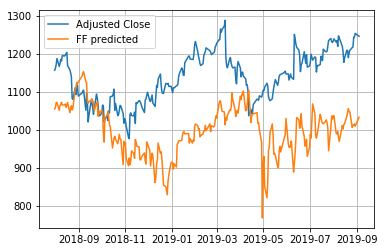

In [26]:
# Plot prediction vs actual
plt.plot(unscaled_data['google_45d'], label='Adjusted Close')
plt.plot(unscaled_seq_predictions['seq_prediction'], label='FF predicted')
plt.grid()
plt.legend()
plt.show()

### LSTM model

#### Split into train and test set
And here you have to be careful according to https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ :

"A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input. In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer. By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function."

But in order to can use "stateful = True" the data has to be a multiple of the batch size. Therefore I have to use modulo to get the test size correctly

In [27]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

In [28]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
# Reshape data for (Sample, Timesteps, Features)
x_train_reshaped = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_reshaped = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [29]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, input_shape = (x_train_reshaped.shape[1], x_train_reshaped.shape[2]), dropout = 0.2, return_sequences = True))
lstm_model.add(LSTM(units = 100, dropout = 0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer = 'adam', loss='mse')
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            56000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 136,501
Trainable params: 136,501
Non-trainable params: 0
_________________________________________________________________


In [30]:
def rolling_lstm_fit_pred(model,x_test,y_test,x_train,y_train):
    predictions = []
    counter = 0
    epochs = 15
    x_train_reshaped = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
    lstm_model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=0);
    for i in range(len(x_test)):
        counter +=1
        if counter%5==0:
            # reshape x_train
            model.reset_states()
            x_train_reshaped = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
            lstm_model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=0);
        # make one-step forecast
        X = x_test[i,:] # select single line
        X = X.reshape(1, 1, len(X))  # reshape for LSTM
        y = y_test[i]
        yhat = lstm_model.predict(X, batch_size=1)[0] # reshape prediction to be just a 1D array
        # store forecast
        predictions.append(yhat[0])
        # add current x_test and y_test line to training data
        if i != len(x_test):
            x_train = np.vstack([x_train, x_test[i]])
            y_train = np.append(y_train, np.array([y_test[1]]), axis=0)
    return predictions

#### Get predictions

In [31]:
# Generate predictions
start_lstm = time.time()
yhat = rolling_lstm_fit_pred(lstm_model,x_test,y_test,x_train,y_train);
raw_lstm_predictions = pd.DataFrame(yhat,columns = ['lstm_prediction'], index = test_index)
end_lstm = time.time()
time_lstm = end_lstm - start_lstm
time_lstm

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1214.0347380638123

#### Convert data

In [32]:
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
y_test = pd.DataFrame(y_test, columns = ['google_45d'], index = test_index)

In [33]:
# Invert scaling for prediction data
unscaled_lstm_predictions = pd.concat([x_test, raw_lstm_predictions], axis=1)
unscaled_lstm_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_lstm_predictions), columns=unscaled_lstm_predictions.columns, index=unscaled_lstm_predictions.index)

# Invert scaling for actual data
test_data_unscaled = pd.concat([x_test, y_test], axis=1)
test_data_unscaled = pd.DataFrame(scaler.inverse_transform(test_data_unscaled), columns=test_data_unscaled.columns, index=test_data_unscaled.index)

In [34]:
backup['unscaled_lstm_predictions'] = unscaled_lstm_predictions
backup['test_data_unscaled'] = test_data_unscaled

In [35]:
lstm_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.google_45d, unscaled_lstm_predictions.lstm_prediction))
print('Accuracy of feedforward model is {} \nAccuracy of LSTM model is {}'.format(round(seq_accuracy,2), round(lstm_accuracy)))

Accuracy of feedforward model is 161.83 
Accuracy of LSTM model is 66.0


/home/matthias/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


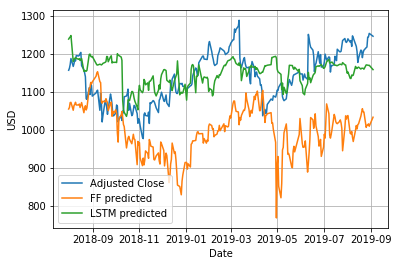

In [3]:
# Plot prediction vs actual
plt.plot(test_data_unscaled['google_45d'], label='Adjusted Close')
plt.plot(unscaled_seq_predictions['seq_prediction'], label='FF predicted')
plt.plot(unscaled_lstm_predictions['lstm_prediction'], label='LSTM predicted')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.legend()
plt.show()

In [37]:
print('Run time for feedforward model is {} seconds \nRun time for LSTM model is {} seconds'.format(time_seq,time_lstm))

Run time for feedforward model is 841.8499984741211 seconds 
Run time for LSTM model is 1214.0347380638123 seconds


In [4]:
backup.close()